## Abstract


## Package import

In [189]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"

import ast
import numpy as np

from tensorflow import keras

In [190]:
#from tensorflow.keras import ops
from tensorflow.keras import layers
import pandas as pd

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from rdkit import Chem, RDLogger
from rdkit.Chem import BondType
from rdkit.Chem.Draw import MolsToGridImage
from rdkit.Chem import Draw
from rdkit import Chem
from rdkit.Chem import rdmolops, AllChem
from tensorflow.keras.regularizers import l1_l2
RDLogger.DisableLog("rdApp.*")

In [191]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)
print("GPU available:", tf.config.list_physical_devices('GPU'))
print("GPU in use:", tf.test.gpu_device_name())

TensorFlow version: 2.16.2
GPU available: []
GPU in use: 


## Database pharsing

In [192]:
'''
read the entire dataset
'''

df = pd.read_csv('dataset1.csv')
df.drop([0,1,2,3,4], inplace=True)
df=df.rename(columns = {'PUBCHEM_EXT_DATASOURCE_SMILES':'SMILES','PUBCHEM_ACTIVITY_OUTCOME':'Activity', 'PUBCHEM_ACTIVITY_SCORE':'Score'})
columns_to_drop = [col for col in df.columns if col not in ['SMILES', 'Activity', 'Score', 'Potency', 'Efficacy']]
df = df.drop(columns = columns_to_drop)
#df=df.drop(['Unnamed: 3','Unnamed: 4','Unnamed: 5'], axis=1)
df = df.dropna(subset=['SMILES'])

df=df.fillna(0)
print(df.head())
print(df.info())

                                              SMILES  Activity  Score  \
5            CNCC1=NC2=C(C=C(C=C2)Cl)C(=N1)C3=CC=CN3  Inactive    0.0   
6                  CCSC(=NC1=CC=C(C=C1)C(F)(F)F)N.Cl  Inactive    0.0   
7  CCN(CC1=CC(=CC=C1)S(=O)(=O)[O-])C2=CC=C(C=C2)C...  Inactive    0.0   
8  CC1=CC=C(C=C1)S(=O)(=O)N2CCN(CC2)C3=NC(=NC4=CC...  Inactive    0.0   
9  CC1=CC=C(C=C1)S(=O)(=O)N2CCN(CC2)C3=NC(=NC4=CC...  Inactive    0.0   

   Potency  Efficacy  
5      0.0       0.0  
6      0.0       0.0  
7      0.0       0.0  
8      0.0       0.0  
9      0.0       0.0  
<class 'pandas.core.frame.DataFrame'>
Index: 342051 entries, 5 to 342072
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   SMILES    342051 non-null  object 
 1   Activity  342051 non-null  object 
 2   Score     342051 non-null  float64
 3   Potency   342051 non-null  float64
 4   Efficacy  342051 non-null  float64
dtypes: float64(3), object(2)
memory u

In [193]:

def is_charged(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if not mol:
        return False  # Invalid SMILES
    return any(atom.GetFormalCharge() != 0 for atom in mol.GetAtoms())

# Test the function
print(is_charged("CC1=C(SC(=C1C#N)NC(=O)C2=CC(C=C2)OC)[N+](=O)"))

True


In [194]:
df['Charged'] = df['SMILES'].apply(is_charged)

uncharged = df[df['Charged'] == False]
uncharged

,SMILES,Activity,Score,Potency,Efficacy,Charged
5,CNCC1=NC2=C(C=C(C=C2)Cl)C(=N1)C3=CC=CN3,Inactive,0.0,0.0,0.0,False
6,CCSC(=NC1=CC=C(C=C1)C(F)(F)F)N.Cl,Inactive,0.0,0.0,0.0,False
8,CC1=CC=C(C=C1)S(=O)(=O)N2CCN(CC2)C3=NC(=NC4=CC...,Inactive,0.0,0.0,0.0,False
9,CC1=CC=C(C=C1)S(=O)(=O)N2CCN(CC2)C3=NC(=NC4=CC...,Inactive,0.0,0.0,0.0,False
10,C1CN(CCN1C2=NC(=NC3=CC=CC=C32)C4=CC=CS4)S(=O)(...,Inactive,0.0,0.0,0.0,False
...,...,...,...,...,...,...
342068,CC(=O)NC1=CC=C(C=C1)OCC2=C(C=CC(=C2)CN(CC3=CC=...,Inactive,0.0,0.0,0.0,False
342069,CC(=O)NC1=CC=C(C=C1)OCC2=C(C=CC(=C2)CN(CC3=CC=...,Inactive,0.0,0.0,0.0,False
342070,CC(=O)NC1=CC=C(C=C1)OCC2=C(C=CC(=C2)CN(CC3=CC=...,Inactive,0.0,0.0,0.0,False
342071,CC(=O)NC1=CC=C(C=C1)C(=O)N(CC2=CC=CC=C2)CC3=CC...,Inactive,0.0,0.0,0.0,False


In [195]:
# Picking all "Active" molecules from the dataset
active_df = uncharged[uncharged['Activity'] == 'Active']
active_df.info()

# Picking all "Inactive" molecules from the dataset
inactive_df = uncharged[uncharged['Activity'] == 'Inactive']
inactive_df.info()

# Randomly sample from inactive_df to match the size of active_df
inactive_sampled = inactive_df.sample(n=len(active_df), random_state=42)

# Combine the active and sampled inactive molecules
balanced_df = pd.concat([active_df, inactive_sampled])

# Shuffle the combined dataset
balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

balanced_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6273 entries, 13 to 341825
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   SMILES    6273 non-null   object 
 1   Activity  6273 non-null   object 
 2   Score     6273 non-null   float64
 3   Potency   6273 non-null   float64
 4   Efficacy  6273 non-null   float64
 5   Charged   6273 non-null   bool   
dtypes: bool(1), float64(3), object(2)
memory usage: 300.2+ KB
<class 'pandas.core.frame.DataFrame'>
Index: 304738 entries, 5 to 342072
Data columns (total 6 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   SMILES    304738 non-null  object 
 1   Activity  304738 non-null  object 
 2   Score     304738 non-null  float64
 3   Potency   304738 non-null  float64
 4   Efficacy  304738 non-null  float64
 5   Charged   304738 non-null  bool   
dtypes: bool(1), float64(3), object(2)
memory usage: 14.2+ MB
<class 'pandas.core.frame.DataFram

In [196]:
filtered_df = balanced_df
filtered_df

,SMILES,Activity,Score,Potency,Efficacy,Charged
0,CC1=C(C=CC=C1Br)NC(=O)C2=C(C=CS2)N3C=CC=C3,Active,82.0,8.9125,140.7280,False
1,CCCCCC(C(C)CC(=O)NC1CCCCC1)C(=O)O,Active,43.0,12.5893,136.6590,False
2,CC1=CC=C(C=C1)S(=O)(=O)NC2=NN3C(C=C(NC3=N2)C)C...,Active,41.0,22.3872,166.6580,False
3,C1CCC2=C(CC1)SC(=C2C(=O)N)NC(=O)C3CC=CCC3C(=O)O,Inactive,0.0,0.0000,0.0000,False
4,COC1=CC=C(C=C1)N2CCN(CC2)C(=O)C3CCN(CC3)S(=O)(...,Inactive,0.0,0.0000,0.0000,False
...,...,...,...,...,...,...
12541,C1CC1C(=O)N=C2N(C3CS(=O)(=O)CC3S2)C4=CC=C(C=C4...,Inactive,0.0,0.0000,0.0000,False
12542,C1=CC=C(C=C1)OC2=NC=NC(=C2)N3C=NC=N3,Active,64.0,2.8184,74.9734,False
12543,CC1=C(C(=CC=C1)N2CCN(CC2)C3=NC4=CC=CC=C4C(=O)N...,Active,42.0,17.7828,126.5240,False
12544,CCC(C)NC(=O)CSC1=NC2=CC=CC=C2C3=NC(C(=O)N31)C4...,Active,42.0,15.8489,139.3040,False


## Parameter setting

In [197]:
'''
scan through all the molecules to obtain unique atom types
'''
smiles = filtered_df['SMILES'].tolist()
search_elements=[]
for smile in smiles:
    mol = Chem.MolFromSmiles(smile)
    atoms = list(set([atom.GetSymbol() for atom in mol.GetAtoms()]))
    search_elements += atoms
    search_elements = list(set(search_elements))
search_elements.append("H")
print(search_elements)

['P', 'O', 'N', 'Na', 'B', 'F', 'C', 'I', 'Cl', 'S', 'Br', 'Si', 'H']


In [198]:
str(search_elements)

"['P', 'O', 'N', 'Na', 'B', 'F', 'C', 'I', 'Cl', 'S', 'Br', 'Si', 'H']"

In [199]:
'''
Setting up the atom mapping and bond mapping. 
Code adopted from https://keras.io/examples/generative/molecule_generation/
'''
SMILE_CHARSET = str(search_elements)

bond_mapping = {"SINGLE": 0, "DOUBLE": 1, "TRIPLE": 2, "AROMATIC": 3}
bond_mapping.update(
    {0: BondType.SINGLE, 1: BondType.DOUBLE, 2: BondType.TRIPLE, 3: BondType.AROMATIC}
)
SMILE_CHARSET = ast.literal_eval(SMILE_CHARSET)

MAX_MOLSIZE = max(filtered_df['SMILES'].str.len())
SMILE_to_index = dict((c, i) for i, c in enumerate(SMILE_CHARSET))
index_to_SMILE = dict((i, c) for i, c in enumerate(SMILE_CHARSET))
atom_mapping = dict(SMILE_to_index)
atom_mapping.update(index_to_SMILE)
print(atom_mapping)
print("Max molecule size: {}".format(MAX_MOLSIZE))
print("Character set Length: {}".format(len(SMILE_CHARSET)))


{'P': 0, 'O': 1, 'N': 2, 'Na': 3, 'B': 4, 'F': 5, 'C': 6, 'I': 7, 'Cl': 8, 'S': 9, 'Br': 10, 'Si': 11, 'H': 12, 0: 'P', 1: 'O', 2: 'N', 3: 'Na', 4: 'B', 5: 'F', 6: 'C', 7: 'I', 8: 'Cl', 9: 'S', 10: 'Br', 11: 'Si', 12: 'H'}
Max molecule size: 202
Character set Length: 13


## Hyperparameters

In [200]:
'''
Defining the Hyperparameters of the model
'''

NUM_ATOMS = 100 #Max number of atoms
ATOM_DIM = len(SMILE_CHARSET)  # Number of atom types
BOND_DIM = 5 # Number of bond types

## Molecule featurization

In [201]:
'''
Defining functions to convert smiles string into node graph and recover molecule structure from it.
Code referenced from: https://keras.io/examples/generative/molecule_generation/
'''


def smiles_to_graph(smiles):
    '''
    Reference: https://keras.io/examples/generative/wgan-graphs/
    '''
    # Converts SMILES to molecule object
    molecule = Chem.MolFromSmiles(smiles)

    # Initialize adjacency and feature tensor
    adjacency = np.zeros((BOND_DIM, NUM_ATOMS, NUM_ATOMS), "float32")
    features = np.zeros((NUM_ATOMS, ATOM_DIM), "float32")

    # loop over each atom in molecule
    for atom in molecule.GetAtoms():
        i = atom.GetIdx()
        atom_type = atom_mapping[atom.GetSymbol()]
        features[i] = np.eye(ATOM_DIM)[atom_type]
        # loop over one-hop neighbors
        for neighbor in atom.GetNeighbors():
            j = neighbor.GetIdx()
            bond = molecule.GetBondBetweenAtoms(i, j)
            bond_type_idx = bond_mapping[bond.GetBondType().name]
            adjacency[bond_type_idx, [i, j], [j, i]] = 1

    # Where no bond, add 1 to last channel (indicating "non-bond")
    # Notice: channels-first
    adjacency[-1, np.sum(adjacency, axis=0) == 0] = 1

    # Where no atom, add 1 to last column (indicating "non-atom")
    features[np.where(np.sum(features, axis=1) == 0)[0], -1] = 1

    return adjacency, features

def graph_to_molecule(adjacency, features):
    # RWMol is a molecule object intended to be edited
    molecule = Chem.RWMol()
    # Remove "no atoms" & atoms with no bonds
    keep_idx = np.where(
        (np.argmax(features, axis=1) != ATOM_DIM - 1)
        & (np.sum(adjacency[:-1], axis=(0, 1)) != 0))[0]

    features = features[keep_idx]
    adjacency = adjacency[:, keep_idx, :][:, :, keep_idx]

    # Add atoms to molecule
    for atom_type_idx in np.argmax(features, axis=1):
        atom = Chem.Atom(atom_mapping[atom_type_idx])
        _ = molecule.AddAtom(atom)

    added_bonds = set()
    (bonds_ij, atoms_i, atoms_j) = np.where(np.triu(adjacency) == 1)
    for (bond_ij, atom_i, atom_j) in zip(bonds_ij, atoms_i, atoms_j):
        if atom_i == atom_j or bond_ij == BOND_DIM - 1:
            continue
        bond_type = bond_mapping.get(bond_ij, None)
        if (atom_i, atom_j) in added_bonds or (atom_j, atom_i) in added_bonds:
            
            continue
        molecule.AddBond(int(atom_i), int(atom_j), bond_type)
        added_bonds.add((atom_i, atom_j))
        

    #Sanitize without Kekulization
    Chem.SanitizeMol(molecule, sanitizeOps=Chem.SanitizeFlags.SANITIZE_ALL ^ Chem.SanitizeFlags.SANITIZE_KEKULIZE)

    # Add explicit hydrogens
    molecule_with_h = Chem.AddHs(molecule)

    # Step 6: Fix Aromaticity in Aromatic Rings
    for atom in molecule_with_h.GetAtoms():
        if atom.GetIsAromatic():
            atom.SetIsAromatic(False)  # Clear aromaticity if needed

    # Step 7: Force Kekulization to alternate bond orders in aromatic rings
    try:
        Chem.Kekulize(molecule_with_h, clearAromaticFlags=True)
    except Chem.KekulizeException as e:
        return molecule_with_h  # Return molecule without Kekulé bonds

    return molecule_with_h

##  Building model

In [202]:
'''
    Defining GCN
    Reference: https://keras.io/examples/generative/wgan-graphs/
    The Encoder takes as input a molecule's graph adjacency matrix and feature matrix.
'''
class RelationalGraphConvLayer(keras.layers.Layer):
    def __init__(
        self,
        units=128,
        activation="relu",
        use_bias=False,
        kernel_initializer="glorot_uniform",
        bias_initializer="zeros",
        kernel_regularizer=None,
        bias_regularizer=None,
        **kwargs
    ):
        super().__init__(**kwargs)

        self.units = units
        self.activation = keras.activations.get(activation)
        self.use_bias = use_bias
        self.kernel_initializer = keras.initializers.get(kernel_initializer)
        self.bias_initializer = keras.initializers.get(bias_initializer)
        self.kernel_regularizer = keras.regularizers.get(kernel_regularizer)
        self.bias_regularizer = keras.regularizers.get(bias_regularizer)

    def build(self, input_shape):
        bond_dim = input_shape[0][1]
        atom_dim = input_shape[1][2]

        self.kernel = self.add_weight(
            shape=(bond_dim, atom_dim, self.units),
            initializer=self.kernel_initializer,
            regularizer=self.kernel_regularizer,
            trainable=True,
            name="W",
            dtype=tf.float32,
        )

        if self.use_bias:
            self.bias = self.add_weight(
                shape=(bond_dim, 1, self.units),
                initializer=self.bias_initializer,
                regularizer=self.bias_regularizer,
                trainable=True,
                name="b",
                dtype=tf.float32,
            )

        self.built = True

    def call(self, inputs, training=False):
        adjacency, features = inputs
        # Aggregate information from neighbors
        x = tf.matmul(adjacency, features[:, None, :, :])
        # Apply linear transformation
        x = tf.matmul(x, self.kernel)
        if self.use_bias:
            x += self.bias
        # Reduce bond types dim
        x_reduced = tf.reduce_sum(x, axis=1)
        # Apply non-linear transformation
        return self.activation(x_reduced)

## Build the Encoder and Decoder


In [203]:
'''
defining function to build encoder and decoder.
Code adopted and modified from https://keras.io/examples/generative/molecule_generation/
'''

def get_encoder(gconv_units, latent_dim, adjacency_shape, feature_shape, dense_units, dropout_rate, regularizer=None):
    adjacency = keras.layers.Input(shape=adjacency_shape, name="adjacency_input")
    features = keras.layers.Input(shape=feature_shape, name="feature_input")
    scores = keras.layers.Input(shape=(1,), name="score_input")  # Conditional input (scalar)

    # Graph convolution layers
    features_transformed = features
    for units in gconv_units:
        features_transformed = RelationalGraphConvLayer(units)(
            [adjacency, features_transformed]
        )

    # Reduce 2D representation to 1D
    x = keras.layers.GlobalAveragePooling1D()(features_transformed)

    # Concatenate the score (condition) to the reduced graph representation
    x = keras.layers.Concatenate()([x, scores])

    # Fully connected layers
    for units in dense_units:
        x = layers.Dense(units, activation="relu", kernel_regularizer=regularizer)(x)
        x = layers.Dropout(dropout_rate)(x)

    # Latent space
    z_mean = layers.Dense(latent_dim, name="z_mean")(x)
    z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)

    # Create encoder model
    encoder = keras.Model(inputs=[adjacency, features, scores], outputs=[z_mean, z_log_var], name="encoder")
    encoder.summary()
    return encoder


class SymmetrizeLayer(layers.Layer):
    def call(self, x):
        return (x + tf.transpose(x, (0, 1, 3, 2))) / 2

def get_decoder(dense_units, latent_dim, adjacency_shape, feature_shape, dropout_rate, regularizer=None):
    latent_input = keras.Input(shape=(latent_dim,), name="latent_input")
    scores = keras.Input(shape=(1,), name="score_input")  # Conditional input (scalar)

    # Concatenate latent input with the conditional score
    x = keras.layers.Concatenate()([latent_input, scores])

    # Dense layers
    for units in dense_units:
        x = keras.layers.Dense(units, activation="tanh", kernel_regularizer=regularizer)(x)
        x = keras.layers.Dropout(dropout_rate)(x)

    # Adjacency reconstruction
    adj_output = keras.layers.Dense(tf.math.reduce_prod(adjacency_shape).numpy().astype(int))(x)
    adj_output = keras.layers.Reshape(adjacency_shape)(adj_output)
    adj_output = SymmetrizeLayer()(adj_output)
    adj_output = keras.layers.Softmax(axis=1)(adj_output)

    # Feature reconstruction
    feat_output = keras.layers.Dense(tf.math.reduce_prod(feature_shape).numpy().astype(int))(x)
    feat_output = keras.layers.Reshape(feature_shape)(feat_output)
    feat_output = keras.layers.Softmax(axis=2)(feat_output)

    # Create decoder model
    decoder = keras.Model(inputs=[latent_input, scores], outputs=[adj_output, feat_output], name="decoder")
    decoder.summary()
    return decoder

## Build the VAE


In [204]:
'''
defining the VAE
Code adopted and modified from https://keras.io/examples/generative/molecule_generation/
'''

class VAE(keras.Model):
    def __init__(self, encoder, decoder, beta=1.0, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.beta = beta

    def call(self, inputs):
        adjacency, features, scores = inputs
        z_mean, z_log_var = self.encoder([adjacency, features, scores])
        z = self.reparameterize(z_mean, z_log_var)
        return self.decoder([z, scores])
    def sampling(self, args):
        """
        Reparameterization trick: Sample from a Gaussian distribution using
        z = z_mean + epsilon * exp(z_log_var / 2), where epsilon is sampled from N(0, 1).
        """
        z_mean, z_log_var = args
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))  # Standard normal noise
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

## Model training

In [205]:
#Hyperparameters
BATCH_SIZE = 128
EPOCHS = 20
VAE_LR = 5e-4 # changed to 1e-3
LATENT_DIM = 512  # Size of the latent space 

In [206]:
'''
splitting the dataset into training and testing
'''

train, test = train_test_split(filtered_df,test_size=0.2,random_state=42)
train_df, val_df = train_test_split(train, test_size=0.2, random_state=42)
train_df.reset_index(drop=True, inplace=True)
val_df.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)

adj_train, fea_train, score_train = [], [], []
adj_val, fea_val, score_val = [], [], []

for idx in range(len(train_df)):
    adjacency, features = smiles_to_graph(train_df.loc[idx]["SMILES"])
    score = train_df.loc[idx]["Activity"]
    adj_train.append(adjacency)
    fea_train.append(features)
    score_train.append(score)

for idx in range(len(val_df)):
    adjacency, features = smiles_to_graph(val_df.loc[idx]["SMILES"])
    score = val_df.loc[idx]["Activity"]
    adj_val.append(adjacency)
    fea_val.append(features)
    score_val.append(score)

    
adj_train = np.array(adj_train)
fea_train = np.array(fea_train)
score_train = np.array(score_train).reshape(-1,1)

adj_val = np.array(adj_val)
fea_val = np.array(fea_val)
score_val = np.array(score_val).reshape(-1,1)

# Right now the values in scores are strings "Active" or "Inactive", so converting them to 0 or 1 
score_train = np.array([(1.0 if score == 'Active' else 0.0) for score in train_df['Activity']]).reshape(-1,1)
score_val = np.array([(1.0 if score == 'Active' else 0.0) for score in val_df['Activity']]).reshape(-1,1)


print(adj_train.shape)
print(fea_train.shape)
print(score_train.shape)
print(adj_val.shape)
print(fea_val.shape)
print(score_val.shape)

(8028, 5, 100, 100)
(8028, 100, 13)
(8028, 1)
(2008, 5, 100, 100)
(2008, 100, 13)
(2008, 1)


In [207]:
'''
compiling the VAE
'''

encoder = get_encoder(
    gconv_units=[9],
    adjacency_shape=(BOND_DIM, NUM_ATOMS, NUM_ATOMS),
    feature_shape=(NUM_ATOMS, ATOM_DIM),
    latent_dim=LATENT_DIM,
    dense_units=[512],
    dropout_rate=0,
    regularizer=l1_l2(l1=1e-3, l2=1e-3)
)
decoder = get_decoder(
    dense_units=[256, 512, 1024],
    dropout_rate=0.2,
    latent_dim=LATENT_DIM,
    adjacency_shape=(BOND_DIM, NUM_ATOMS, NUM_ATOMS),
    feature_shape=(NUM_ATOMS, ATOM_DIM), 
    regularizer=l1_l2(l1=1e-3, l2=1e-3)
)
vae = VAE(encoder, decoder)

vae.compile(optimizer=keras.optimizers.Adam(learning_rate=VAE_LR))


Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ adjacency_input     │ (None, 5, 100,    │          0 │ -                 │
│ (InputLayer)        │ 100)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ feature_input       │ (None, 100, 13)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ relational_graph_c… │ (None, 100, 9)    │        585 │ adjacency_input[… │
│ (RelationalGraphCo… │                   │            │ feature_input[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 9)         │          0 │ relational_graph… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ score_input         │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_18      │ (None, 10)        │          0 │ global_average_p… │
│ (Concatenate)       │                   │            │ score_input[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_54 (Dense)    │ (None, 512)       │      5,632 │ concatenate_18[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_36          │ (None, 512)       │          0 │ dense_54[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 512)       │    262,656 │ dropout_36[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 512)       │    262,656 │ dropout_36[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 531,529 (2.03 MB)

 Trainable params: 531,529 (2.03 MB)

 Non-trainable params: 0 (0.00 B)

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ latent_input        │ (None, 512)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ score_input         │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_19      │ (None, 513)       │          0 │ latent_input[0][… │
│ (Concatenate)       │                   │            │ score_input[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_55 (Dense)    │ (None, 256)       │    131,584 │ concatenate_19[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_37          │ (None, 256)       │          0 │ dense_55[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_56 (Dense)    │ (None, 512)       │    131,584 │ dropout_37[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_38          │ (None, 512)       │          0 │ dense_56[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_57 (Dense)    │ (None, 1024)      │    525,312 │ dropout_38[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_39          │ (None, 1024)      │          0 │ dense_57[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_58 (Dense)    │ (None, 50000)     │ 51,250,000 │ dropout_39[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_18          │ (None, 5, 100,    │          0 │ dense_58[0][0]    │
│ (Reshape)           │ 100)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_59 (Dense)    │ (None, 1300)      │  1,332,500 │ dropout_39[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ symmetrize_layer_9  │ (None, 5, 100,    │          0 │ reshape_18[0][0]  │
│ (SymmetrizeLayer)   │ 100)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_19          │ (None, 100, 13)   │          0 │ dense_59[0][0]    │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ softmax_18          │ (None, 5, 100,    │          0 │ symmetrize_layer… │
│ (Softmax)           │ 100)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ softmax_19          │ (None, 100, 13)   │          0 │ reshape_19[0][0]  │
│ (Softmax)           │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 53,370,980 (203.59 MB)

 Trainable params: 53,370,980 (203.59 MB)

 Non-trainable params: 0 (0.00 B)

In [208]:
train_dataset = tf.data.Dataset.from_tensor_slices((adj_train, fea_train, score_train)).batch(BATCH_SIZE)
val_dataset = tf.data.Dataset.from_tensor_slices((adj_val, fea_val, score_val)).batch(BATCH_SIZE)
val_loss_list = []
train_loss_list = []
beta_list = []
prev_rec_loss = float('inf')
reconstruction_loss = 0
beta = 5

In [209]:
for epoch in range(EPOCHS):
    print(f"Epoch {epoch + 1}/{EPOCHS}")
    
    if reconstruction_loss < prev_rec_loss * 0.99:
        beta = max(beta * 0.8, 0)  
        rec_bounce = 0
    if reconstruction_loss*0.99 < prev_rec_loss or reconstruction_loss >= prev_rec_loss * 0.99:
        beta = min(beta * 1.2, 10)
        
    prev_rec_loss = reconstruction_loss
    
    # Training Loop
    train_loss = 0
    for step, (adjacency, features, scores) in enumerate(train_dataset):
        with tf.GradientTape() as tape:
            # Forward pass
            z_mean, z_log_var = vae.encoder([adjacency, features, scores])
            z = vae.sampling([z_mean, z_log_var])
            adj_reconstruction, feature_reconstruction = vae.decoder([z, scores])

            # Compute losses
            adj_loss = tf.reduce_mean(
                tf.reduce_sum(keras.losses.binary_crossentropy(adjacency, adj_reconstruction), axis=(1, 2))
            )
            feat_loss = tf.reduce_mean(
                tf.reduce_sum(keras.losses.categorical_crossentropy(features, feature_reconstruction), axis=1)
            )
            reconstruction_loss = 0.6*adj_loss + 0.4*feat_loss
            kl_loss = -0.5 * tf.reduce_mean(
                tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1)
            )
            total_loss = reconstruction_loss + beta * kl_loss

        # Backpropagation
        grads = tape.gradient(total_loss, vae.trainable_weights)
        vae.optimizer.apply_gradients(zip(grads, vae.trainable_weights))

        train_loss += total_loss

    train_loss /= len(train_dataset)
    train_loss_list.append(train_loss)
    print(f"Train Loss: {train_loss.numpy()}, KL Loss: {kl_loss.numpy()}, Reconstruction Loss: {reconstruction_loss.numpy()}")

    # Validation Loop
    val_loss = 0
    for val_step, (val_adjacency, val_features, val_scores) in enumerate(val_dataset):
        # Forward pass
        z_mean, z_log_var = vae.encoder([val_adjacency, val_features, val_scores])
        z = vae.sampling([z_mean, z_log_var])
        val_adj_reconstruction, val_feat_reconstruction = vae.decoder([z, val_scores])

        # Compute losses
        val_adj_loss = tf.reduce_mean(
            tf.reduce_sum(keras.losses.binary_crossentropy(val_adjacency, val_adj_reconstruction), axis=(1, 2))
        )
        val_feat_loss = tf.reduce_mean(
            tf.reduce_sum(keras.losses.categorical_crossentropy(val_features, val_feat_reconstruction), axis=1)
        )
        val_reconstruction_loss = 0.6*val_adj_loss + 0.4*val_feat_loss
        val_kl_loss = -0.5 * tf.reduce_mean(
            tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1)
        )
        val_total_loss = val_reconstruction_loss + beta * val_kl_loss

        val_loss += val_total_loss

    val_loss /= len(val_dataset)
    val_loss_list.append(val_loss)
    print(f"Validation Loss: {val_loss.numpy()}, KL Loss: {val_kl_loss.numpy()}, Reconstruction Loss: {val_reconstruction_loss.numpy()}")
    print('BETA is: ', beta)

Epoch 1/20


2024-12-12 19:19:05.768580: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Train Loss: 354.10235595703125, KL Loss: 7.257534980773926, Reconstruction Loss: 15.963855743408203


2024-12-12 19:19:06.861086: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation Loss: 44.997802734375, KL Loss: 6.346437454223633, Reconstruction Loss: 22.972505569458008
BETA is:  4.8
Epoch 2/20


2024-12-12 19:19:29.930798: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Train Loss: 47.549312591552734, KL Loss: 4.85502290725708, Reconstruction Loss: 15.760952949523926


2024-12-12 19:19:31.054338: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation Loss: 42.59856414794922, KL Loss: 4.876525402069092, Reconstruction Loss: 15.692119598388672
BETA is:  5.76
Epoch 3/20


2024-12-12 19:19:53.866961: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Train Loss: 40.17800521850586, KL Loss: 2.93227481842041, Reconstruction Loss: 24.356233596801758


2024-12-12 19:19:54.943637: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation Loss: 36.46419143676758, KL Loss: 3.6202759742736816, Reconstruction Loss: 15.782600402832031
BETA is:  5.529599999999999
Epoch 4/20


2024-12-12 19:20:17.580756: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Train Loss: 42.353965759277344, KL Loss: 2.100186586380005, Reconstruction Loss: 19.31340789794922


2024-12-12 19:20:18.591881: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation Loss: 40.38208770751953, KL Loss: 1.880214810371399, Reconstruction Loss: 24.110549926757812
BETA is:  6.635519999999999
Epoch 5/20


2024-12-12 19:20:40.633159: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Train Loss: 34.32841491699219, KL Loss: 1.0229188203811646, Reconstruction Loss: 25.131839752197266


2024-12-12 19:20:41.775636: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation Loss: 36.18843078613281, KL Loss: 1.1190695762634277, Reconstruction Loss: 23.093948364257812
BETA is:  6.370099199999999
Epoch 6/20


2024-12-12 19:21:04.635537: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Train Loss: 29.907747268676758, KL Loss: 0.5845609903335571, Reconstruction Loss: 18.349803924560547


2024-12-12 19:21:05.647965: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation Loss: 27.67254638671875, KL Loss: 0.5311570763587952, Reconstruction Loss: 28.056976318359375
BETA is:  7.644119039999999
Epoch 7/20


2024-12-12 19:21:29.830475: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Train Loss: 20.368507385253906, KL Loss: 0.2413962334394455, Reconstruction Loss: 16.083946228027344


2024-12-12 19:21:30.885564: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation Loss: 17.033262252807617, KL Loss: 0.21482649445533752, Reconstruction Loss: 16.38956642150879
BETA is:  7.338354278399999
Epoch 8/20


2024-12-12 19:21:53.515050: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Train Loss: 16.20811653137207, KL Loss: 0.16124947369098663, Reconstruction Loss: 15.978540420532227


2024-12-12 19:21:54.620381: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation Loss: 15.751976013183594, KL Loss: 0.13916558027267456, Reconstruction Loss: 15.72751235961914
BETA is:  7.044820107263999
Epoch 9/20


2024-12-12 19:22:19.567653: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Train Loss: 15.72175407409668, KL Loss: 0.08825791627168655, Reconstruction Loss: 15.737601280212402


2024-12-12 19:22:20.831054: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation Loss: 15.357146263122559, KL Loss: 0.07493431121110916, Reconstruction Loss: 15.602715492248535
BETA is:  8.453784128716798
Epoch 10/20


2024-12-12 19:22:44.623328: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Train Loss: 15.301192283630371, KL Loss: 0.05630992725491524, Reconstruction Loss: 15.784552574157715


2024-12-12 19:22:45.702986: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation Loss: 15.078747749328613, KL Loss: 0.04923532158136368, Reconstruction Loss: 15.521394729614258
BETA is:  8.115632763568126
Epoch 11/20


2024-12-12 19:23:09.556887: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Train Loss: 15.19783878326416, KL Loss: 0.040069468319416046, Reconstruction Loss: 15.640121459960938


2024-12-12 19:23:10.620858: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation Loss: 14.992874145507812, KL Loss: 0.03531428799033165, Reconstruction Loss: 15.52355670928955
BETA is:  9.738759316281751
Epoch 12/20


2024-12-12 19:23:34.500167: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Train Loss: 15.114550590515137, KL Loss: 0.029547492042183876, Reconstruction Loss: 15.645719528198242


2024-12-12 19:23:35.571301: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation Loss: 14.913211822509766, KL Loss: 0.026499314233660698, Reconstruction Loss: 15.527665138244629
BETA is:  10
Epoch 13/20


2024-12-12 19:23:59.375100: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Train Loss: 15.031689643859863, KL Loss: 0.023044196888804436, Reconstruction Loss: 15.617304801940918


2024-12-12 19:24:00.466387: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation Loss: 14.876113891601562, KL Loss: 0.021066095679998398, Reconstruction Loss: 15.53009033203125
BETA is:  10
Epoch 14/20


2024-12-12 19:24:24.271535: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Train Loss: 14.984929084777832, KL Loss: 0.019118914380669594, Reconstruction Loss: 15.54969596862793


2024-12-12 19:24:25.417048: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation Loss: 14.842723846435547, KL Loss: 0.01737288013100624, Reconstruction Loss: 15.596192359924316
BETA is:  10
Epoch 15/20


2024-12-12 19:24:48.892448: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Train Loss: 14.95639419555664, KL Loss: 0.01623588055372238, Reconstruction Loss: 15.633577346801758


2024-12-12 19:24:50.014081: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation Loss: 14.82510757446289, KL Loss: 0.015040209516882896, Reconstruction Loss: 15.611796379089355
BETA is:  10
Epoch 16/20


2024-12-12 19:25:14.523991: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Train Loss: 14.942658424377441, KL Loss: 0.014064806513488293, Reconstruction Loss: 15.61688232421875


2024-12-12 19:25:15.623752: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation Loss: 14.79636001586914, KL Loss: 0.013078742660582066, Reconstruction Loss: 15.654770851135254
BETA is:  10
Epoch 17/20


2024-12-12 19:25:40.590219: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Train Loss: 14.920835494995117, KL Loss: 0.012414174154400826, Reconstruction Loss: 15.600530624389648


2024-12-12 19:25:41.633611: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation Loss: 14.775039672851562, KL Loss: 0.011233367957174778, Reconstruction Loss: 15.592341423034668
BETA is:  10
Epoch 18/20


2024-12-12 19:26:05.318817: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Train Loss: 14.905017852783203, KL Loss: 0.011154665611684322, Reconstruction Loss: 15.679685592651367


2024-12-12 19:26:06.422528: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation Loss: 14.76690673828125, KL Loss: 0.009682298637926579, Reconstruction Loss: 15.523500442504883
BETA is:  10
Epoch 19/20


2024-12-12 19:26:30.076941: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Train Loss: 14.896068572998047, KL Loss: 0.009958400391042233, Reconstruction Loss: 15.601973533630371


2024-12-12 19:26:31.130515: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation Loss: 14.751607894897461, KL Loss: 0.008370521478354931, Reconstruction Loss: 15.547245025634766
BETA is:  10
Epoch 20/20


2024-12-12 19:26:55.933334: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Train Loss: 14.877449989318848, KL Loss: 0.009016817435622215, Reconstruction Loss: 15.692041397094727
Validation Loss: 14.750031471252441, KL Loss: 0.007434666156768799, Reconstruction Loss: 15.573405265808105
BETA is:  10


2024-12-12 19:26:56.986385: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [210]:
'''
Checking the model's ability to reconstruct a molecule from the training dataset
'''

i=8
adjacency_check, features_check = smiles_to_graph(train_df.loc[i]["SMILES"])
score_check = [train_df.loc[i]["Activity"]]
molobj = Chem.MolFromSmiles(train_df.loc[i]["SMILES"])
adj0 = np.expand_dims(adjacency_check,axis=0)
feature0 = np.expand_dims(features_check,axis=0)
score0 = np.expand_dims(score_check,axis=0)
print(adj0.shape)
print(feature0.shape)
print(score0.shape)
# z_mean_pred, z_log_var_pred= vae.encoder.predict([adj0,feature0,score0])
# z_pred = vae.sampling([z_mean_pred, z_log_var_pred])
# adj_pred, feature_pred = vae.decoder.predict([z_pred,score0])
# adj_pred = tf.argmax(adj_pred, axis=1)
# adj_pred = tf.one_hot(adj_pred, depth=BOND_DIM, axis=1)
# adj_pred = tf.linalg.set_diag(adj_pred, tf.zeros(tf.shape(adj_pred)[:-1]))
# feature_pred = tf.argmax(feature_pred, axis=2)
# feature_pred = tf.one_hot(feature_pred, depth=ATOM_DIM, axis=2)



# mole_pred1 = graph_to_molecule([adj_pred.numpy()[0], feature_pred.numpy()[0]])
mole_pred = graph_to_molecule([adj0[0], feature0[0]])
Draw.MolsToGridImage([molobj,mole_pred], molsPerRow=2,)

(1, 5, 100, 100)
(1, 100, 13)
(1, 1)


TypeError: graph_to_molecule() missing 1 required positional argument: 'features'

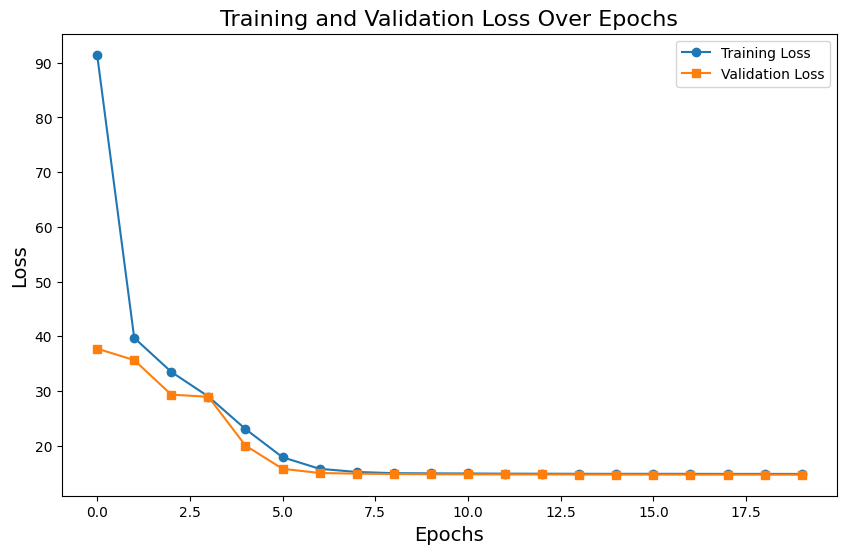

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(range(EPOCHS), train_loss_list, label='Training Loss', marker='o')
plt.plot(range(EPOCHS), val_loss_list, label='Validation Loss', marker='s')

# Add title and labels
plt.title('Training and Validation Loss Over Epochs', fontsize=16)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend()
plt.show()

## Visualize latent space

In [ ]:
adj_test, fea_test, score_test = [], [], []

for idx in range(len(test)):
    adjacency, features = smiles_to_graph(test.loc[idx]["SMILES"])
    score = test.loc[idx]["Score"]
    adj_test.append(adjacency)
    fea_test.append(features)
    score_test.append(score)


adj_test = np.array(adj_test)
fea_test = np.array(fea_test)
score_test = np.array(score_test).reshape(-1,1)

In [ ]:
ls_train = vae.encoder.predict([adj_train, fea_train, score_train])
ls_test = vae.encoder.predict([adj_test, fea_test, score_test])

251/251 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [ ]:
ls_train_ = np.array(ls_train)
ls_test_ = np.array(ls_test)

In [ ]:
z_mean, _ = vae.encoder.predict([adj_test, fea_test, score_test])

79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


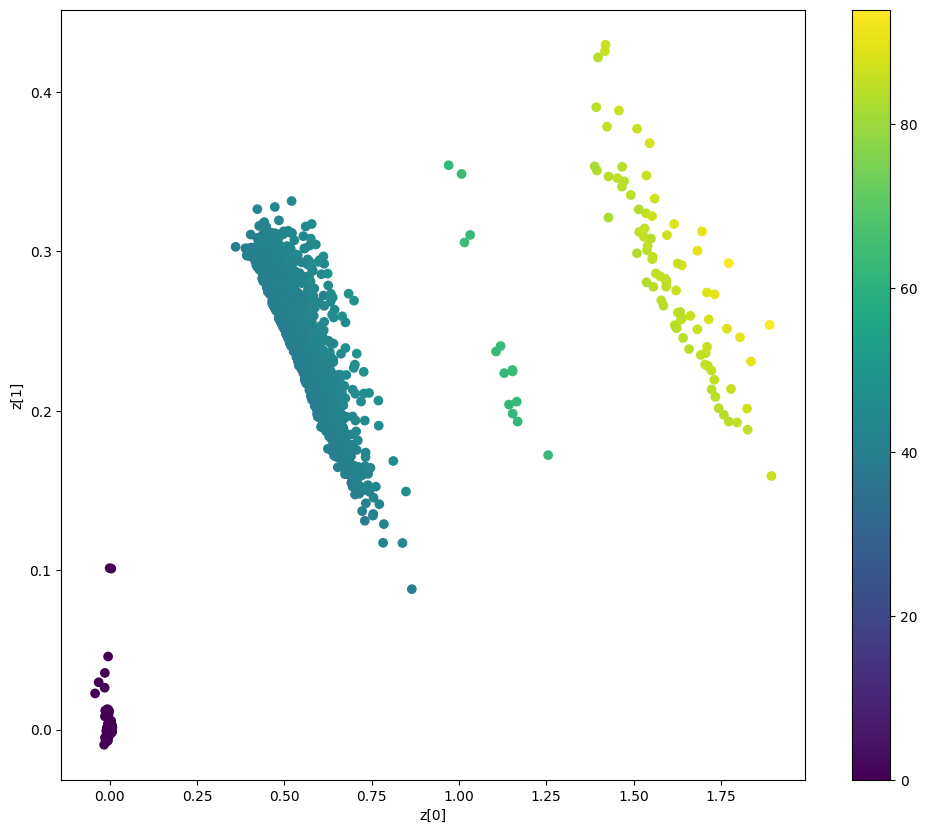

In [ ]:
plt.figure(figsize=(12, 10))
plt.scatter(z_mean[:, 0], z_mean[:, 1], c=score_test)
plt.colorbar()
plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.show()

In [ ]:
z_mean2, _2 = vae.encoder.predict([adj_train, fea_train, score_train])

251/251 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


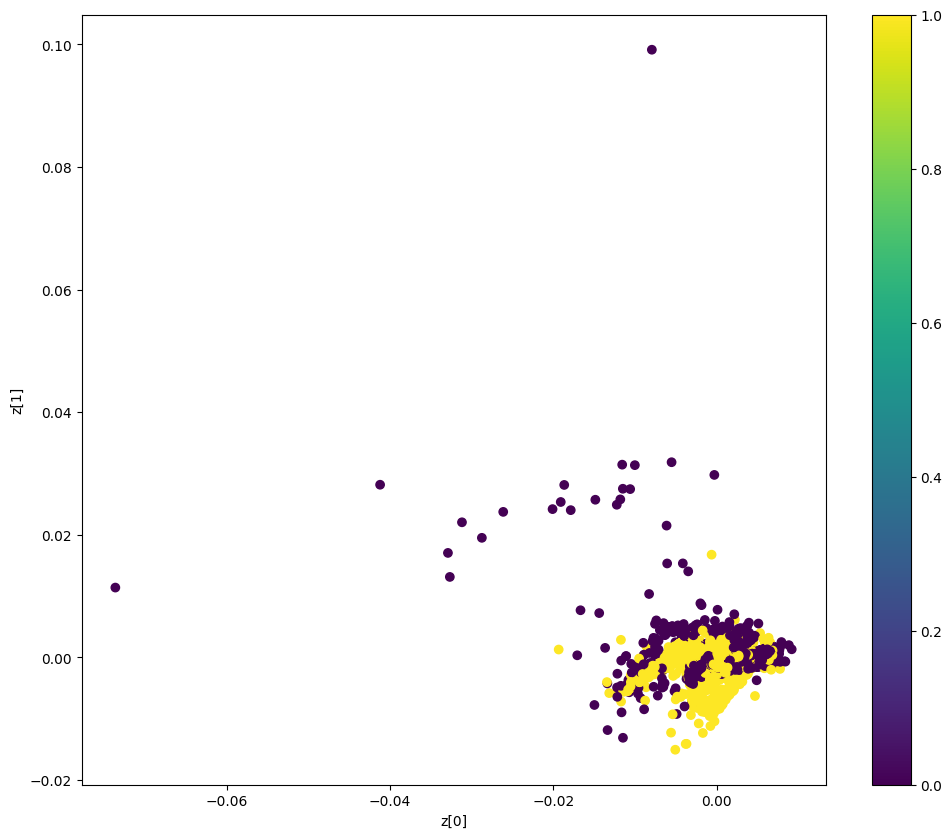

In [ ]:
plt.figure(figsize=(12, 10))
plt.scatter(z_mean2[:, 0], z_mean2[:, 1], c=score_train)
plt.colorbar()
plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.show()

## Model Inferencing

We would be inferring our model to predict over random latent space and try to generate 100 new valid molecules.

### Generate unique Molecules with the model

In [ ]:
def inference(model=vae, batch_size=1000, dim = LATENT_DIM, activity=1):
    z = np.random.normal(size=(batch_size, dim))
    activityarray = (np.zeros(batch_size) + activity).reshape(-1,1)

    reconstruction_adjacency, reconstruction_features = model.decoder.predict([z,activityarray])
    # obtain one-hot encoded adjacency tensor
    adjacency = tf.argmax(reconstruction_adjacency, axis=1)
    adjacency = tf.one_hot(adjacency, depth=BOND_DIM, axis=1)
    # Remove potential self-loops from adjacency
    adjacency = tf.linalg.set_diag(adjacency, tf.zeros(tf.shape(adjacency)[:-1]))
    # obtain one-hot encoded feature tensor
    features = tf.argmax(reconstruction_features, axis=2)
    features = tf.one_hot(features, depth=ATOM_DIM, axis=2)

    return [
        graph_to_molecule(adjacency[i].numpy(), features[i].numpy())
        for i in range(batch_size)
    ]

In [ ]:
gen_mols = inference(batch_size=1000,activity=1)
MolsToGridImage(
     [m for m in gen_mols if m is not None][:1000], molsPerRow=5, subImgSize=(260, 160)
)

In [ ]:
import os
from datetime import datetime
# Create output directory if it doesn't exist
output_dir = "generated_molecules"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Get current timestamp for unique folder name
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
run_dir = os.path.join(output_dir, f"run_{timestamp}")
os.makedirs(run_dir)

valid_count = 0
iterations = 20
for i in range(iterations):
    
    # Random latent vector and target score
    random_z = np.random.normal(size=(1, LATENT_DIM))
    target_score = np.array([[1]]) 

    # Generate predictions
    adjacency_pred, feature_pred = vae.decoder.predict([random_z, target_score])
    adjacency_pred = adjacency_pred*3
    # Post-process predictions
    threshold = 0.5
    adjacency_pred_processed = (adjacency_pred > threshold).astype(int)  # Binary
    adjacency_pred_processed = np.maximum(
        adjacency_pred_processed, 
        np.transpose(adjacency_pred_processed, (0, 1, 3, 2))  # Swap last two dimensions
    )
    feature_pred_processed = tf.one_hot(np.argmax(feature_pred, axis=-1), depth=ATOM_DIM).numpy()  # One-hot

    # Debug prints
    #print("Processed Adjacency Matrix Shape:", adjacency_pred_processed[0].shape)
    #print("Processed Feature Matrix Shape:", feature_pred_processed[0].shape)

    # Generate the molecule
    generated_molecule = graph_to_molecule(adjacency_pred_processed[0], feature_pred_processed[0])

    # Visualize or print the molecule
    if generated_molecule:
        valid_count += 1
        smiles = Chem.MolToSmiles(generated_molecule)
        
        # Create filename using molecule index and SMILES string (truncated if too long)
        truncated_smiles = smiles[:50]  # Truncate SMILES to prevent filename length issues
        safe_smiles = "".join(c if c.isalnum() else "_" for c in truncated_smiles)  # Remove special characters
        filename = f"molecule_{valid_count:04d}_{safe_smiles}"
        
        # Save the molecule image
        img_path = os.path.join(run_dir, f"{filename}.png")
        Draw.MolToFile(generated_molecule, img_path, size=(300, 300))
        
        # Save SMILES string to a text file
        with open(os.path.join(run_dir, "molecules.txt"), "a") as f:
            f.write(f"Molecule {valid_count}: {smiles}\n")
        
        #print(f"Generated SMILES: {smiles}")
        #print(f"Saved image to: {img_path}")        
    else:
        print("Failed to generate a valid molecule.")

print(f"\nGeneration complete! Generated {valid_count} valid molecules out of {iterations} runs.")
#print(f"Output directory: {run_dir}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━

KeyboardInterrupt: 